## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
# import dataframe_image as dfi
from project_functions.utils import picklify, unpickle
from project_functions.visualizations import configure_axislabels_and_title, configure_ticklabels_and_params
from project_functions.visualizations import configure_legend, plot_confusion_matrix_fancy
from project_functions.visualizations import encode_target, get_scores_as_frame, get_all_scores
import warnings
warnings.filterwarnings('ignore')

/home/joshua/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load Data

In [2]:
# Load test data, including encoded version of y_test
X_test_count_unigrams = unpickle('../data/cleaned/test/X_test_count_unigrams.pickle')
X_test_count_bigrams = unpickle('../data/cleaned/test/X_test_count_bigrams.pickle')
X_test_gensim_2gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_2gram_sparse.pickle').T
X_test_gensim_3gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_3gram_sparse.pickle').T
X_test_gensim_4gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_4gram_sparse.pickle').T
X_test_glove = unpickle('../data/cleaned/test/X_test_glove.pickle')
X_test_word2vec = unpickle('../data/cleaned/test/X_test_word2vec.pickle')
y_test = unpickle('../data/cleaned/test/y_test.pickle')
y_test_encoded = encode_target(y_test)

In [3]:
# Load trained models
mnb_count_unigrams = unpickle('../data/models/mnb_count_unigrams.pickle')
mnb_count_bigrams = unpickle('../data/models/mnb_count_bigrams.pickle')
mnb_gensim_2gram = unpickle('../data/models/mnb_gensim_2gram.pickle')
mnb_gensim_3gram = unpickle('../data/models/mnb_gensim_3gram.pickle')
mnb_gensim_4gram = unpickle('../data/models/mnb_gensim_4gram.pickle')
baseline_xg_gensim_2gram = unpickle('../data/models/baseline_xg_gensim_2gram.pickle')
best_xg_gensim_2gram = unpickle('../data/models/best_xg_gensim_2gram.pickle')
baseline_xg_gensim_3gram = unpickle('../data/models/baseline_xg_gensim_3gram.pickle')
best_xg_gensim_3gram = unpickle('../data/models/best_xg_gensim_3gram.pickle')
baseline_xg_gensim_4gram = unpickle('../data/models/baseline_xg_gensim_4gram.pickle')
best_xg_gensim_4gram = unpickle('../data/models/best_xg_gensim_4gram.pickle')
baseline_xg_glove = unpickle('../data/models/baseline_xg_glove.pickle')
best_xg_glove = unpickle('../data/models/best_xg_glove.pickle')
baseline_xg_word2vec = unpickle('../data/models/baseline_xg_word2vec.pickle')
best_xg_word2vec = unpickle('../data/models/best_xg_word2vec.pickle')

## Confusion Matrix

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


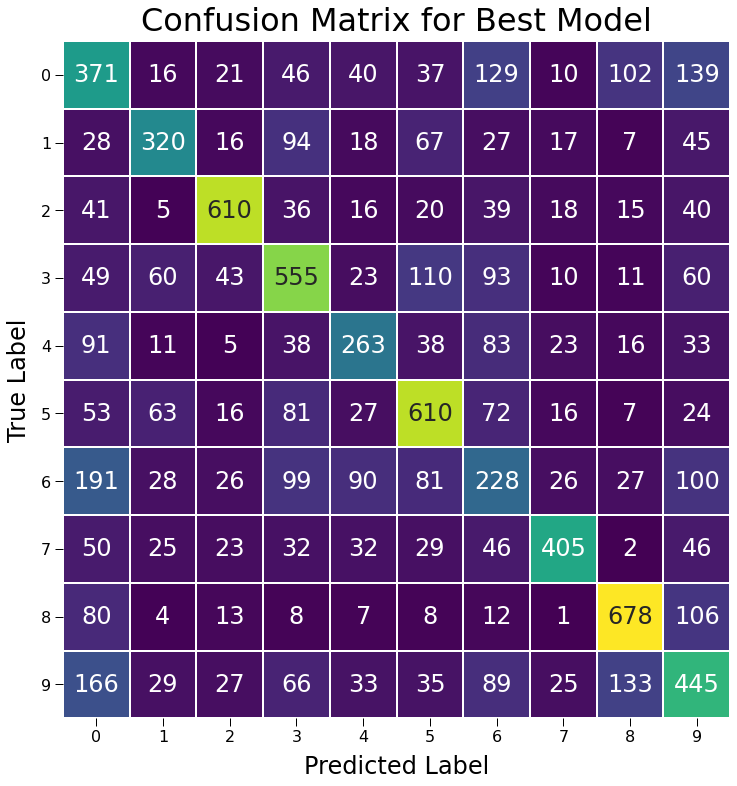

In [4]:
# Create confusion matrix for best model (tuned XGBoosted tree with gensim 4-gram encoding)
# Create fig, ax objects and seaborn heatmap of confusion matrix
fig, ax = plot_confusion_matrix_fancy(X_test_gensim_4gram_sparse, y_test_encoded, best_xg_gensim_4gram);

# Configure axis labels and title
configure_axislabels_and_title('Predicted Label', 'True Label', 'Confusion Matrix for Best Model', ax = ax)

# Configure tick labels and parameters
configure_ticklabels_and_params(ax = ax)

# Save figure
plt.savefig('../visualizations/best_model_confusion_matrix.png', bbox_inches = 'tight')

## TSNE

In [5]:
# Load TSNE data for gensim 4-gram encoded data, split into train and test sets
tsne_gensim_4gram = unpickle('../data/tsne/tsne_gensim_4gram.pickle')
tsne_gensim_4gram_train_only = tsne_gensim_4gram.loc[~tsne_gensim_4gram.index.isin(y_test.index)]
tsne_gensim_4gram_test_only = tsne_gensim_4gram.loc[tsne_gensim_4gram.index.isin(y_test.index)]

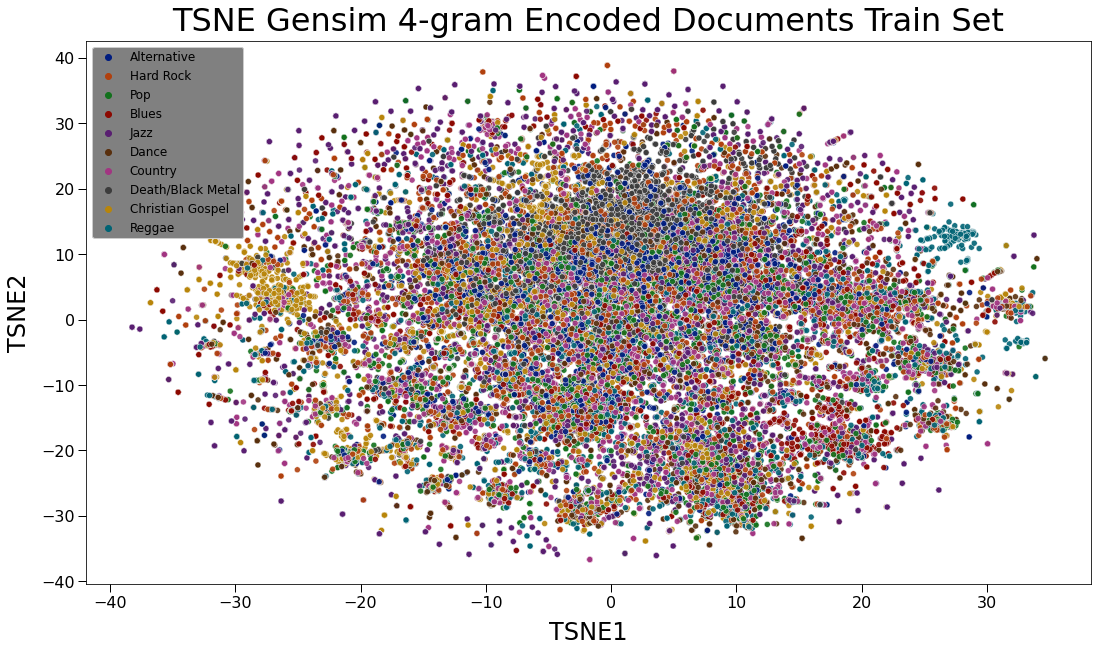

In [6]:
# Create TSNE plot using gensim 4-gram encoded data and ground-truth labels
# Create fig, ax objects
fig, ax = plt.subplots(figsize = (18, 10))

# Create seaborn scatterplot
sns.scatterplot(data = tsne_gensim_4gram_train_only, x = 'TSNE1', y = 'TSNE2',
                hue = 'genre', palette = 'dark', alpha = 0.9);

# Configure axis labels and title
configure_axislabels_and_title('TSNE1', 'TSNE2', 'TSNE Gensim 4-gram Encoded Documents Train Set', ax = ax)

# Configure tick labels and parameters
configure_ticklabels_and_params(ax = ax)

# Configure legend
labels = ['Alternative', 'Hard Rock', 'Pop', 'Blues', 'Jazz', 'Dance',
          'Country', 'Death/Black Metal', 'Christian Gospel', 'Reggae']
configure_legend(ax = ax, labels = labels, loc = 2, labelcolor = 'black', frameon = True, facecolor = 'grey',
                 fontsize = 12, fancybox = True, framealpha = 1, borderpad = 0.3)

# Save figure
plt.savefig('../visualizations/TSNE_gensim_4gram_train.png', bbox_inches = 'tight')

In [7]:
# Create genre predictions for test set, put into dataframe
predicted_genres = best_xg_gensim_4gram.predict(X_test_gensim_4gram_sparse)
predicted_genres = pd.DataFrame(predicted_genres, columns = ['predicted_genre'], index = y_test.index)

# Create map from prediction labels back to genres
genre_map = {
    0: 'Alternative',
    1: 'Blues',
    2: 'Christian Gospel',
    3: 'Country',
    4: 'Dance',
    5: 'Jazz',
    6: 'Pop',
    7: 'Reggae',
    8: 'Death/Black Metal',
    9: 'Hard Rock'
}

# Join predictions to TSNE data for test set
tsne_gensim_4gram_test_only = pd.concat([tsne_gensim_4gram_test_only, predicted_genres], axis = 1)
tsne_gensim_4gram_test_only.predicted_genre = tsne_gensim_4gram_test_only.predicted_genre.replace(genre_map)

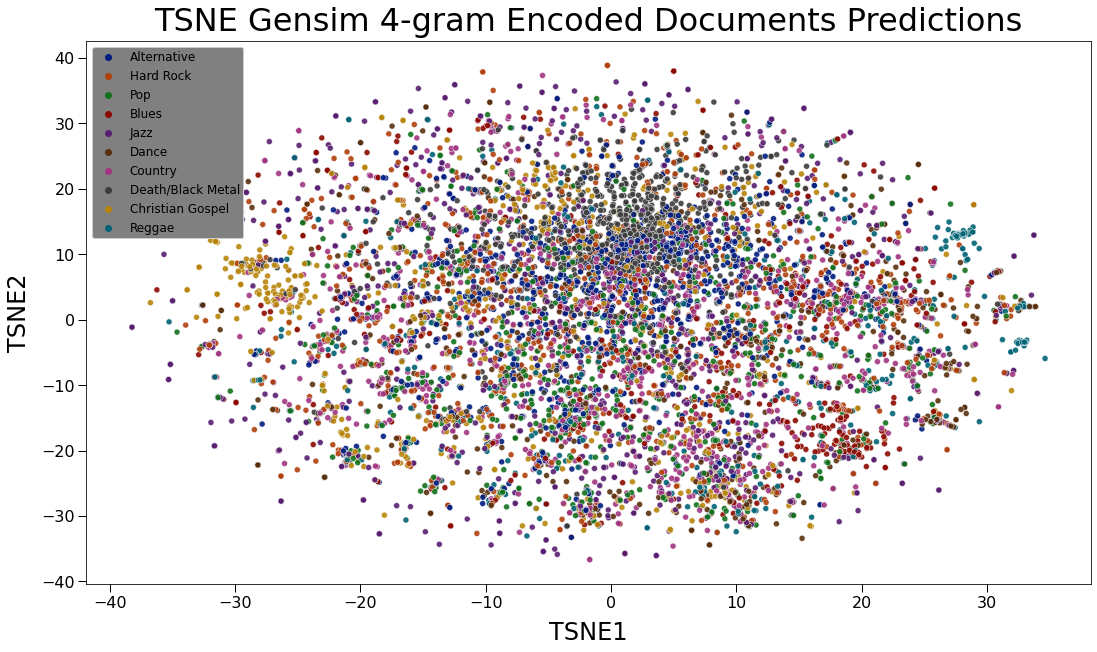

In [8]:
# Create TSNE plot using gensim 4-gram encoding and predicted labels for test data
# Create fig, ax objects
fig, ax = plt.subplots(figsize = (18, 10))

# Create labels for hue ordering and legend configuration
labels = ['Alternative', 'Hard Rock', 'Pop', 'Blues', 'Jazz', 'Dance',
          'Country', 'Death/Black Metal', 'Christian Gospel', 'Reggae']

# Create seaborn scatterplot
sns.scatterplot(data = tsne_gensim_4gram_test_only, x = 'TSNE1', y = 'TSNE2',
                hue = 'predicted_genre', hue_order = labels, palette = 'dark', alpha = 0.9);

# Configure axis labels and title
configure_axislabels_and_title('TSNE1', 'TSNE2', 'TSNE Gensim 4-gram Encoded Documents Predictions', ax = ax)

# Configure tick labels and parameters
configure_ticklabels_and_params(ax = ax)

# Configure legend
configure_legend(ax = ax, labels = labels, loc = 2, labelcolor = 'black', frameon = True, facecolor = 'grey',
                 fontsize = 12, fancybox = True, framealpha = 1, borderpad = 0.3)

# Save figure
plt.savefig('../visualizations/TSNE_gensim_4gram_test.png', bbox_inches = 'tight')

## Genre Counts

In [9]:
# Load in complete data frame with genres containing > 3000 records
tokenized_data_main_genres = pd.read_parquet('../data/cleaned/tokenized_data_large_genres.parquet')

# Extract and inspect the genre counts
genre_values = tokenized_data_main_genres.genre_name.value_counts()
genre_values

Rock-Hard-Rock                  5242
Country                         5070
Jazz                            4845
Rock-Death-Metal-Black-Metal    4587
Alternative                     4555
Pop                             4479
Christian-Gospel                4198
Reggae                          3451
Blues                           3193
Dance                           3004
Name: genre_name, dtype: int64

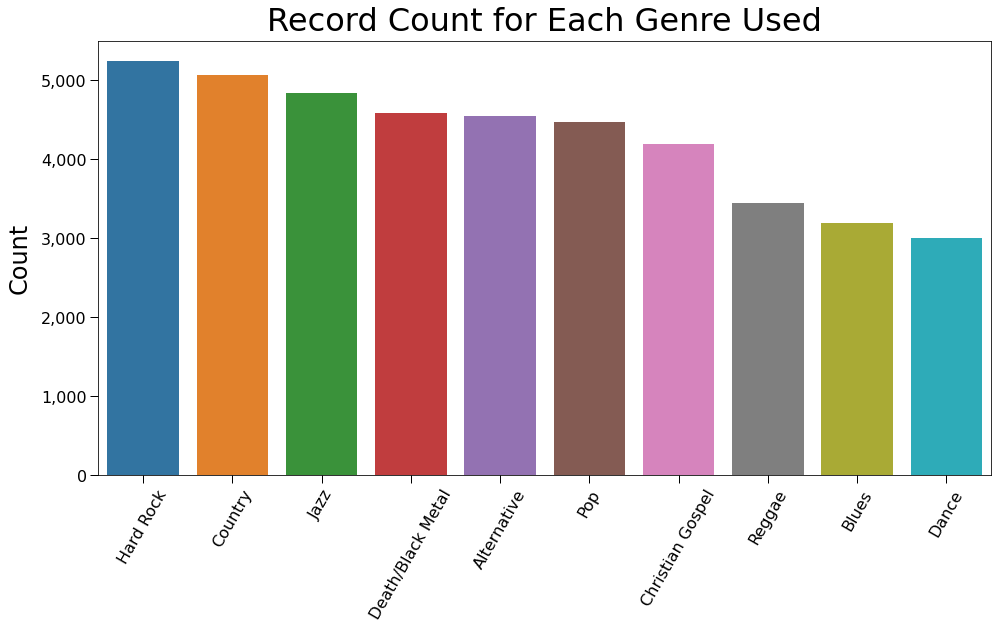

In [10]:
# Create barplot for genre counts, sorted in descending order
# Construct fig, ax objects
fig, ax = plt.subplots(figsize = (16, 8))

# Create seaborn barplot
sns.barplot(x = genre_values.index.tolist(), y = genre_values.values.tolist());

# Configure axis labels and title
configure_axislabels_and_title(None, 'Count', 'Record Count for Each Genre Used', ax = ax)

# Configure ticklabels and parameters
configure_ticklabels_and_params(ax = ax, format_yticks = True, x_ticks_rotation = 60);
ax.set_xticklabels(['Hard Rock', 'Country', 'Jazz', 'Death/Black Metal', 'Alternative', 'Pop',
                    'Christian Gospel', 'Reggae', 'Blues', 'Dance']);


# Save figure
plt.savefig('../visualizations/genre_count.png', bbox_inches = 'tight')

## Classification Report

In [11]:
# Print classification for best model (tuned XGBoosted model using gensim 4-grams) for inspection
# Use values to populate Google Slides presentation
print(classification_report(y_test_encoded, best_xg_gensim_4gram.predict(X_test_gensim_4gram_sparse)))

              precision    recall  f1-score   support

           0       0.33      0.41      0.37       911
           1       0.57      0.50      0.53       639
           2       0.76      0.73      0.74       840
           3       0.53      0.55      0.54      1014
           4       0.48      0.44      0.46       601
           5       0.59      0.63      0.61       969
           6       0.28      0.25      0.27       896
           7       0.74      0.59      0.65       690
           8       0.68      0.74      0.71       917
           9       0.43      0.42      0.43      1048

    accuracy                           0.53      8525
   macro avg       0.54      0.53      0.53      8525
weighted avg       0.53      0.53      0.53      8525



## Model Scores

In [12]:
# Create lists of test sets, models, and model labels in preparation for scoring
X_tests = [X_test_count_unigrams, X_test_count_bigrams,
           X_test_gensim_2gram_sparse, X_test_gensim_3gram_sparse, X_test_gensim_4gram_sparse,
           X_test_gensim_2gram_sparse, X_test_gensim_3gram_sparse, X_test_gensim_4gram_sparse,
           X_test_gensim_2gram_sparse, X_test_gensim_3gram_sparse, X_test_gensim_4gram_sparse,
           X_test_glove, X_test_word2vec, X_test_glove, X_test_word2vec]
models = [mnb_count_unigrams, mnb_count_bigrams,
          mnb_gensim_2gram, mnb_gensim_3gram, mnb_gensim_4gram,
          baseline_xg_gensim_2gram, baseline_xg_gensim_3gram, baseline_xg_gensim_4gram,
          best_xg_gensim_2gram, best_xg_gensim_3gram, best_xg_gensim_4gram,
          baseline_xg_glove, baseline_xg_word2vec, best_xg_glove, best_xg_word2vec]
model_labels = ['mnb_count_uni', 'mnb_count_bi', 'mnb_gen_2g', 'mnb_gen_3g', 'mnb_gen_4g',
                'base_xg_gen_2g', 'base_xg_gen_3g', 'base_xg_gen_4g',
                'best_xg_gen_2g', 'best_xg_gen_3g', 'best_xg_gen_4g',
                'base_xg_glove', 'base_xg_word2vec', 'best_xg_glove', 'best_xg_word2vec']
 
# Get dataframe of scores for models and inspect sorted scores in descending order
# Use information to populate Google Slides presentation
scores = get_all_scores(X_tests, y_test_encoded, models, model_labels)
scores.sort_values('accuracy', ascending = False)

,model,accuracy
0,best_xg_gen_4g,0.526100
0,best_xg_gen_3g,0.524575
0,best_xg_gen_2g,0.522933
0,mnb_gen_3g,0.501935
0,mnb_gen_2g,0.501818
0,mnb_gen_4g,0.500528
0,base_xg_gen_4g,0.498534
0,base_xg_gen_2g,0.494780
0,base_xg_gen_3g,0.494663
0,best_xg_word2vec,0.477654
